In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor

sns.set(color_codes=True)

In [11]:
def mse(y_test, y_true):
    return np.mean((y_test - y_true) ** 2)

def expo_fit(y):
    x = np.arange(-y.shape[0], 0)
    return np.exp(np.polyfit(x, np.log(y), 1)[1])

### Step I: Import the data that has already been cleaned and merged

In [6]:
data = pd.read_csv("all_in_1.csv")

X, y = data.drop(columns=['4/18/20']), data['4/18/20']

### Step II: Visualizations (Feel free to skip this part if you want)

In [12]:
results = []
for j in range(86,89):
    result = []
    for i in range(j-12, j-2):
        y_mat = X.iloc[:,i:j].to_numpy()
        exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
        exp_predict[np.isnan(exp_predict)] = 0
        result.append(mse(exp_predict, X.iloc[:,j]))
    results.append(result)

# special handling for interpolating 4/18/20 data
result = []
for i in range(78, 88):
    y_mat = X.iloc[:,i:90].to_numpy()
    exp_predict = np.apply_along_axis(expo_fit, 1, y_mat)
    exp_predict[np.isnan(exp_predict)] = 0
    result.append(mse(exp_predict, y))

results.append(result)

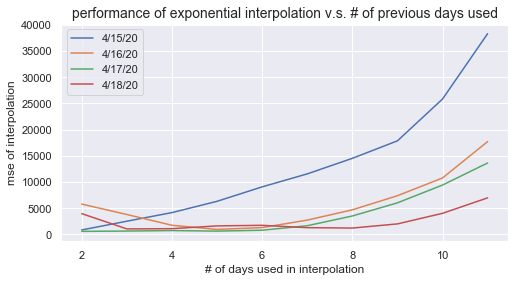

In [16]:
x = np.arange(11, 1, -1)
labels = ['4/15/20', '4/16/20', '4/17/20', '4/18/20']
plt.figure(figsize=(8, 4))
for i in range(4):
    plt.plot(x, results[i], label=labels[i])
plt.legend()
plt.ylabel("mse of interpolation")
plt.xlabel("# of days used in interpolation")
plt.title("performance of exponential interpolation v.s. # of previous days used", fontsize=14);

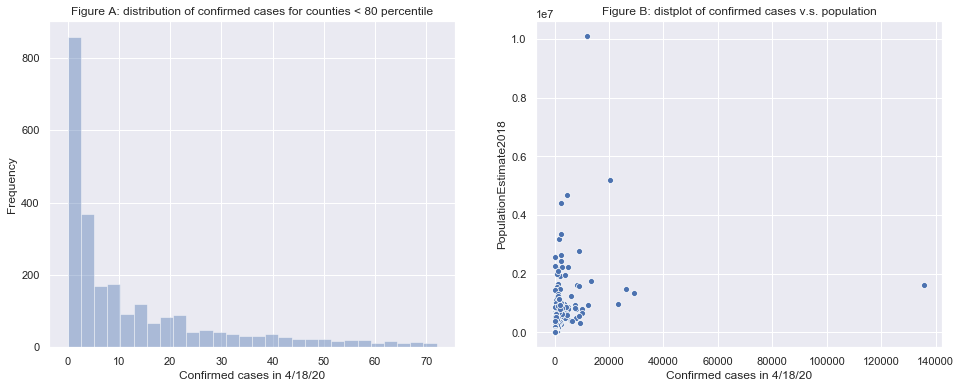

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(y[y < np.percentile(y, 80)], kde=False)
plt.xlabel("Confirmed cases in 4/18/20")
plt.ylabel("Frequency")
plt.title("Figure A: distribution of confirmed cases for counties < 80 percentile");

plt.subplot(1, 2, 2)
sns.scatterplot(x="4/18/20", y="PopulationEstimate2018", data=data)
plt.xlabel("Confirmed cases in 4/18/20")
plt.title("Figure B: distplot of confirmed cases v.s. population");

### 3. Simple Regressors (LinearRegression v.s. DecisionTree)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X[['4/15/20', '4/16/20', '4/17/20']], y, test_size=0.1, random_state=42)

In [58]:
linear_regr = LinearRegression(normalize=True)
linear_regr.fit(X_train, y_train)

tree_regr = DecisionTreeRegressor(max_depth=20)
tree_regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [67]:
linear_pred = np.round(np.maximum(0, linear_regr.predict(X_test)))
linear_mse = mse(linear_pred, y_test)
tree_pred = np.round(tree_regr.predict(X_test))
tree_mse = mse(tree_pred, y_test)

linear_mse, tree_mse

(62.62420382165605, 210.60191082802547)

#### Check the mse for prediction of counties with small confirmed cases

In [74]:
small_indices = np.argwhere(y_test < 50).flatten()
a = y_test.to_numpy()[small_indices]
"""
Linear
"""
b = linear_pred[small_indices]
"""
Decision Tree
"""
c = tree_pred[small_indices]

print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}")

Linear mse: 5.4471544715447155, Tree mse: 2.508130081300813


In [75]:
big_indices = np.argwhere(y_test >= 50).flatten()
a = y_test.to_numpy()[big_indices]
"""
Linear
"""
b = linear_pred[big_indices]
"""
Decision Tree
"""
c = tree_pred[big_indices]

print(f"Linear mse: {mse(a, b)}, Tree mse: {mse(a, c)}")

Linear mse: 269.47058823529414, Tree mse: 963.4117647058823
